In [65]:
import pandas as pd
import numpy as np

# Tools
import pickle
import joblib

# Metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve, precision_score, recall_score
from sklearn.metrics import f1_score, fbeta_score
from sklearn.metrics import roc_auc_score, roc_curve, auc

# Comparison
from sklearn.ensemble import VotingClassifier
from imblearn.pipeline import Pipeline

# Visualizations
from xgboost import plot_importance
from matplotlib import pyplot
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use('seaborn-whitegrid')

In [31]:
# Load train and test sets
X_train_under = pd.read_pickle('../data/03_X_train_under.pkl')
X_test        = pd.read_pickle('../data/03_X_test.pkl')
y_train_under = pd.read_pickle('../data/03_y_train_under.pkl')
y_test        = pd.read_pickle('../data/03_y_test.pkl')

In [29]:
# load models from disk
lgr_best = joblib.load('../models/lgr_best.sav')
knn_best = joblib.load('../models/knn_best.sav')
rfc_best = joblib.load('../models/rfc_best.sav')
xgb_best = joblib.load('../models/xgb_best.sav')

# result = xgb_best.score(X_test, y_test)
# print(result)

# Model comparison

In [13]:
# Load pickle
with open('../data/04_model_performance.pkl', 'rb') as f:
    model_performance = pickle.load(f)
    f.close()

In [19]:
model_performance_df = pd.DataFrame(data=model_performance)
model_performance_df = model_performance_df[['Model', 'ROC AUC', 'Precision', 'Recall', 'F1']]
model_performance_df.sort_values(by='F1', ascending=False).reset_index(drop=True)

,Model,ROC AUC,Precision,Recall,F1
0,XGBoost,0.822,0.571,0.805,0.668
1,Logistic Regression,0.744,0.432,0.750,0.548
2,Random Forest,0.722,0.433,0.680,0.529
3,KNN,0.701,0.389,0.691,0.498


## ROC AUC Curves

In [20]:
def plot_roc_curves(classifiers, X_train, y_train, X_test, y_test, sampler = None):
    """
        Function for plotting roc curves of classifiers for comparison
        
        :param classifiers: dictionary of classifiers
        :param sampler: sampling method to use e.g. smote
        
        :returns fpr: an array of false positive rate values from roc_curve
        :returns tpr: an array of true positive rate values from roc_curve
        :returns thresholds: an array of threshold values from roc_curve
        :returns roc_auc: roc_auc scores for each classifier in classifiers
        
        https://github.com/kevinchiv/Predicting-Kickstarter-Success/blob/master/02%20-%20Classification%20Modeling.ipynb
    """
    fpr, tpr, thresholds = {}, {}, {}
    roc_auc = {}
    print('ROC AUC Scores\n')
    for classifier_name, classifier in classifiers.items():
        #set n_jobs = -1 for faster performance
        classifier = classifier.set_params(n_jobs = -1)
#         if sampler:
#             sampler.set_params(random_state = 42, n_jobs = -1)
        steps = [('sampling', sampler),
                 (classifier_name, classifier)]
        model = Pipeline(steps)
        model.fit(X_train, y_train)
        y_proba = model.predict_proba(X_test)[:,1]
        fpr[classifier_name], tpr[classifier_name], thresholds[classifier_name] = roc_curve(y_test, y_proba)
        roc_auc[classifier_name] = round(auc(fpr[classifier_name], tpr[classifier_name]), 3)
        print(classifier_name + str(roc_auc[classifier_name]))

    plt.figure(figsize=(8, 8))
    for classifier_name, classifier in classifiers.items():
        sns.lineplot(fpr[classifier_name], tpr[classifier_name], err_style = None);

    midline_points = np.arange(0, 1.05, 0.05) 

    plt.plot(midline_points, midline_points, linestyle ='--', color = 'black');
    plt.title("ROC Curves for Different Classification Models", y =1.05, fontsize = 16);
    plt.xlabel('FPR', fontsize = 12, x = 1.05);
    plt.ylabel('TPR', fontsize = 12, rotation =0, y = 1.05);
    plt.legend(list(zip(classifiers.keys(), roc_auc.values())));

    return fpr, tpr, thresholds, roc_auc

KNN roc_auc score: 0.776


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LGR roc_auc score: 0.832
RF roc_auc score: 0.82
XGB roc_auc score: 0.905
Ensemble roc_auc score: 0.889


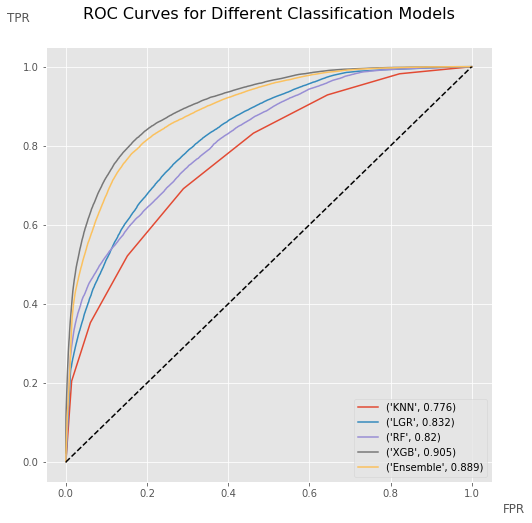

In [34]:
classifiers = {'XGB': xgb_best,
               'LGR': lgr_best, 
               'RF': rfc_best,
               'KNN': knn_best,
               'Ensemble': VotingClassifier(estimators=[('lrg', lgr_best), ('rfc', rfc_best), ('xgb', xgb_best)],
                                            voting='soft', weights=[1, 1, 1])
              }

fpr, tpr, thresholds, roc_auc = plot_roc_curves(classifiers, X_train_under, y_train_under, X_test, y_test)

# Confusion Matrix

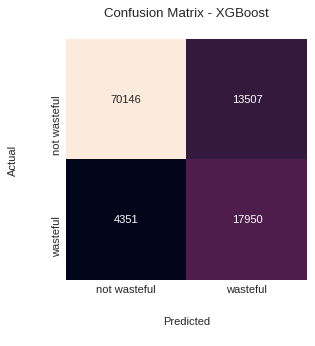

In [73]:
# Load pickle
with open('../data/04_xgb_best_preds.pkl', 'rb') as f:
    xgb_best_preds = pickle.load(f)
    f.close()

# Print confusion matrix for XGBoost
xgb_confusion = confusion_matrix(y_test, xgb_best_preds)

plt.figure(dpi=80)
sns.heatmap(xgb_confusion, annot=True, fmt='g', square=True, cbar=False,
            xticklabels=['not wasteful', 'wasteful'],
            yticklabels=['not wasteful', 'wasteful'])

plt.title('Confusion Matrix - XGBoost', pad=20)
plt.xlabel('Predicted\n', labelpad=20)
plt.ylabel('Actual\n', labelpad=20);

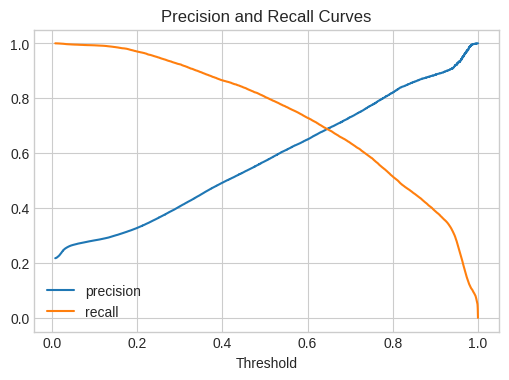

In [91]:
# Precision & Recall curves
precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, xgb_best.predict_proba(X_test)[:,1])

plt.figure(dpi=100)
plt.plot(threshold_curve, precision_curve[1:], label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold');
plt.title('Precision and Recall Curves');

In [55]:
# F1 score, default threshold
round(f1_score(y_test.values, xgb_best_preds), 3)

0.668

In [96]:
# Tune threshold value for optimal f1 score
threshold_scores = {}
for t in np.linspace(0.1, 1, 10):
    y_pred = xgb_best.predict_proba(X_test)[:, 1] > t
    threshold_scores[t] = round(f1_score(y_test.values, y_pred), 3)
    
print(threshold_scores)

{0.1: 0.44, 0.2: 0.49, 0.30000000000000004: 0.564, 0.4: 0.627, 0.5: 0.668, 0.6: 0.687, 0.7000000000000001: 0.681, 0.8: 0.633, 0.9: 0.54, 1.0: 0.0}


The optimal threshold value is  0.6


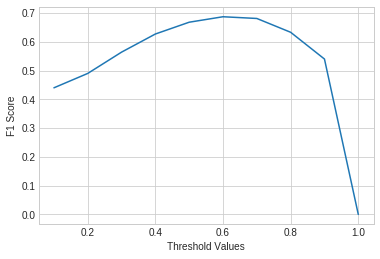

In [97]:
# Find best threshold
keys = list(threshold_scores.keys())
values = list(threshold_scores.values())
threshold = keys[values.index(max(values))]

# Plot F1 scores
print('The optimal threshold value is ', threshold)
plt.plot(keys, values)
plt.xlabel('Threshold Values')
plt.ylabel('F1 Score');

Optimal threshold for XGBoost model is **.6** with an F1 Score of **.7**

In [ ]:
# Confusion matrix
print('\nConfusion Matrix\n' + str(confusion_matrix(y_test, xgb_best_preds)))

# Feature Importance

In [ ]:
# Feature Importance – XGBoost
fig, ax = plt.subplots(figsize=(12,18))
# xgb_best.get_booster().feature_names = list(X_test.columns)
plot_importance(xgb_best.get_booster(), max_num_features=15, height=0.8, ax=ax)
plt.title('Feature Importance')

# import matplotlib.pylab as pl
# plot_importance(xgb_best.get_booster(), max_num_features=15)
# plt.title("xgboost.plot_importance(model)")
# plt.show()

In [89]:
# Load pickle
with open('../data/03_X.pkl', 'rb') as f:
    X = pickle.load(f)
    f.close()

# Appendix

## Shap

In [ ]:
# import shap

# # this takes a minute or two since we are explaining over 30 thousand samples in a model with over a thousand trees
# explainer = shap.TreeExplainer(xgb_best)
# shap_values = explainer.shap_values(X)

In [ ]:
# # Visualize a single prediction
# shap.force_plot(explainer.expected_value, shap_values[0,:], X_display.iloc[0,:])

### Mean of Importance
This takes the average of the SHAP value magnitudes across the dataset and plots it as a simple bar chart.

In [ ]:
# shap.summary_plot(shap_values, X_display, plot_type="bar")

In [ ]:
# shap.summary_plot(shap_values, X)